## Random Forest Classifier
Random forest classifier is a machine learning technique used to predict discrete classes. In theory, it can be used to predict multiple classes, but here, we'll just focus on the dichotomous case. Random forests are able to diverse sets of data, including binary data, categorical data, and continuous data.

Random forests are based on decision trees. Decision trees classify an outcome variable by splitting each predictor variable into an either or statement. The following is an example of a simple decision for determining whether to take a job: 
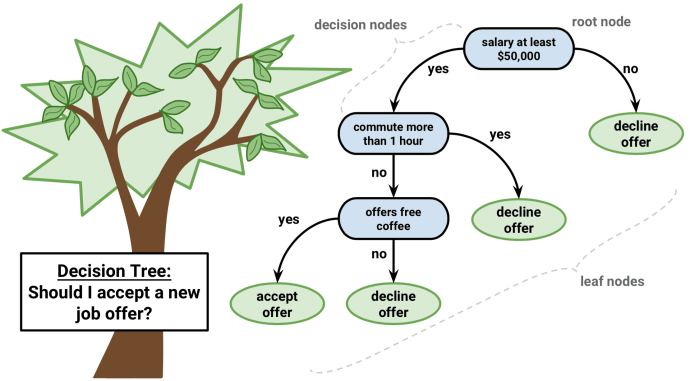 (from https://towardsdatascience.com/decision-tree-hugging-b8851f853486)

We could think of this as a classification task if we are trying to predict whether somone will take a job based on the predictor variables salary, commute time, and presence of free coffee.

The strength of random forest is that it combines multiple decision trees in trying to predict an outcome variable. The decision trees are created by randomly choosing predictor variables at each node. The idea is that by randomly creating a large number of trees, the trees that predict the outcome variable poorly will cancel, leaving only the trees which predict the outcome variable really well.

In addition to making predictions, a random forest can determine which predictor variables are the most useful to making the prediction. These can be thought of as serving the same purpose as regression coefficients in regression models.

In this session, we'll try to accomplish the following:  
1) create a simple random forest model for our computational instruction dataset  
2) Use the RF model to predict if a faculty member uses computation in their physics course  
3) Assess our RF model using a ROC curve  
4) determine which predictor variables are most useful for classifying the data  

## Building a random forest model
First we need to load our dataset. Some implementations of random forest don't handle missing data well. Here, we've removed all the faculty who didn't answer all the questions so there are no missing values.

In [4]:
df=read.csv("c:/Users/Nick/Dropbox/_PER/MSU PER/Machine Learning/compdataset.csv")

A model isn't really useful if we don't know how good the model is. For that reason, we want to test our model. Typically, this is done by only growing the random forest from part of the available data and using the rest to see how well the random forest can predict from data it hasn't seen before.  
Let's use 75% of the available data to train the model and keep 25% of it off to the side for now.

In [5]:
set.seed(1) #make our random results reproducible
comp_dt=sort(sample(nrow(df),nrow(df)*.75)) #randomly select 75% of the data
train <-df[comp_dt,] #construct a new dataframe from the selected data for training the model
test <- df[-comp_dt,] #construct a new dataframe from the unselected data for model validation

Let's use the randomForest library for the random forest algorithm. Load it with library().

In [6]:
library(randomForest)

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.


Vec2 shows all the questions that both faculty who do and do not use computation both answered. Let's just pick a few for now. We'll put them in a variable called quest.  
For reference:   
Q125: Computation is important for undergrads (strongly disagree to strongly agree)  
Q131: Computation is used across science (strongly disagree to strongly agree)  
Q137: Computation allows me to bring new physics in (strongly disagree to strongly agree)  
Q152: Highest degree of faculty member (PhD, Masters, other)  
Q163: I use computation in research with students (yes or no)  
Q170: Gender (male, female, prefer not to answer)  
Q187: Highest degree offered by institution (Associates, Bachelors, Masters, PhD)  
Q190: Race/ethnicity (11 categories)

In [7]:
vec2=c('Q124','Q125','Q126','Q127', 'Q128','Q129','Q130','Q131','Q132','Q133',
       'Q134','Q135','Q136','Q137','Q138','Q139','Q140','Q141','Q142','Q143',
       'Q144','Q145','Q146','Q147','Q148','Q152','Q153','Q154','Q155','Q156',
       'Q157','Q158','Q160','Q162','Q163','Q164','Q166','Q168','Q169','Q170',
       'Q190','Q185','Q186','Q187')
quest=c('Q125','Q131','Q137','Q152','Q163','Q170','Q187','Q190')

The randomForest() function needs a formula. It's a pain to write one by hand for a large number of questions, so use the reformulate() function. The first spot is what we are predicting from and the second spot is what we are predicting

In [8]:
formula=reformulate(quest,'Q1')
print(formula)

Q1 ~ Q125 + Q131 + Q137 + Q152 + Q163 + Q170 + Q187 + Q190


Now let's run the random forest model. We need to tell the model what to predict and what to predict it from. This is given by the formula. Next, we need to say which data to use. Finally, we need to say to use generate the importances for each variable so we can see which variables are the most useful for predicting Q1, whether a faculty has experience teaching computation.

In [9]:
set.seed(1)
rf.output<-randomForest(formula,data=train, importance=TRUE)

Now let's look at the results. The OOB gives the model's ability to correctly predict the data in the training set. The confusion matrix gives the details. Rows are the actual value and the columns are the predicted value.

In [10]:
print(rf.output)


Call:
 randomForest(formula = formula, data = train, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 2

        OOB estimate of  error rate: 26.59%
Confusion matrix:
    No Yes class.error
No  99  90   0.4761905
Yes 48 282   0.1454545


## Validating the model
We've constructed a random forest model. Now we need to check that it is a good model. We do that by seeing how well it can predict on data it hasn't seen before and generating a ROC curve.  
For this part, we've need a few packages, so let's add them now.

In [11]:
library(ROCR) #ROC curve stuff
library(caret) #confusion matrix and other statistical stuff

Loading required package: gplots
Warning message:
"package 'gplots' was built under R version 3.4.3"
Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess

Warning message:
"package 'caret' was built under R version 3.4.3"Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.4.3"Loading required package: ggplot2

Attaching package: 'ggplot2'

The following object is masked from 'package:randomForest':

    margin



First, let's try predicting on the "test" data that the random forest model hasn't seen before. Then we'll use the confusionMatrix() function to look at the result

In [12]:
predictions=predict(rf.output,test) #make the predictions on the "test" dataset
confusionMatrix(unlist(test['Q1']),unlist(predictions),positive='Yes')

Confusion Matrix and Statistics

          Reference
Prediction No Yes
       No  42  31
       Yes 16  85
                                          
               Accuracy : 0.7299          
                 95% CI : (0.6575, 0.7943)
    No Information Rate : 0.6667          
    P-Value [Acc > NIR] : 0.04385         
                                          
                  Kappa : 0.4291          
 Mcnemar's Test P-Value : 0.04114         
                                          
            Sensitivity : 0.7328          
            Specificity : 0.7241          
         Pos Pred Value : 0.8416          
         Neg Pred Value : 0.5753          
             Prevalence : 0.6667          
         Detection Rate : 0.4885          
   Detection Prevalence : 0.5805          
      Balanced Accuracy : 0.7284          
                                          
       'Positive' Class : Yes             
                                          

What a good accuracy will be depends on the application. Here, we really only care that it is better than what we could get by just classifying everything as the more common response to Q1; this is the no information rate.  
  
We also want to look at the pos pred value and neg pred value. These measure how well the model predicts postive responses (do teach computation) and negative responses (do not teach computation). Ideally, these should be the same so that the model is equally adept predicting positive and negative cases.  
  
Now, let's make a ROC curve. We need to do some intermediate commands first.  
Previously, we've predicted whether a faculty has experience teaching computation. Now, we want to get the probability that they have experience teaching computation.

In [13]:
comp_pred=predict(rf.output,type='prob') #generate probabilities of not having or having experience teaching computation
comp_train_perf=prediction(comp_pred[,2],train$Q1) #make object with just probabilities of having experience

From the prediction object, we need to get the true positive rate and the false positive rate to make the ROC curve. Use the performance() function for that. Then use the plot function to make the curve. Let's also add the chance line.  
The ROC curve shows us how changing the false positive rate affects the true positive rate. 

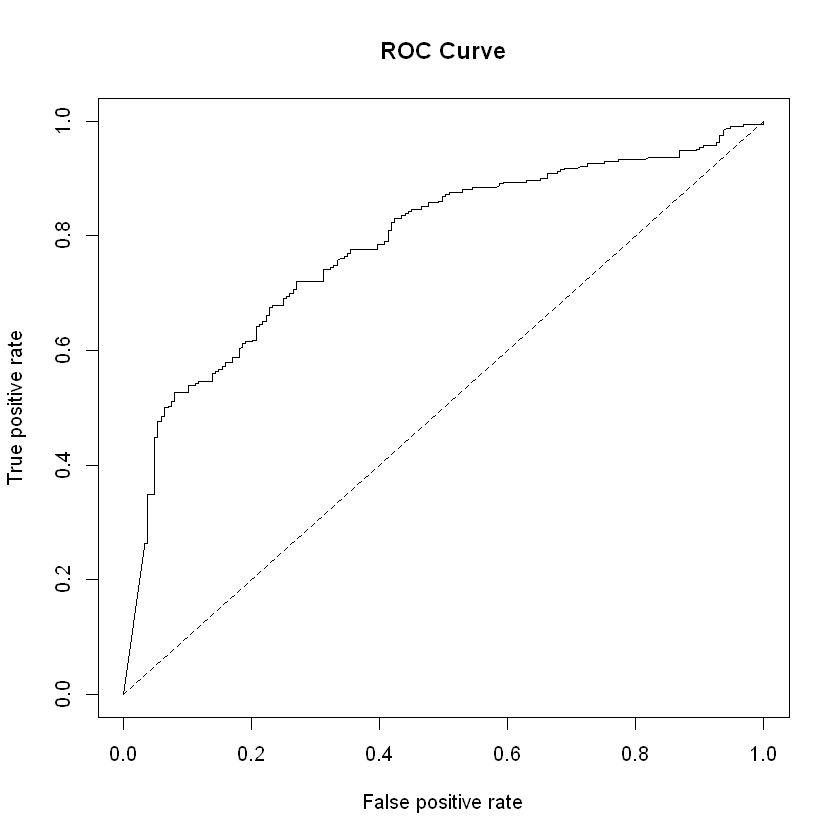

In [14]:
comp_roc=performance(comp_train_perf,'tpr','fpr') #generate the fpr and tpr
plot(comp_roc, main='ROC Curve') #plot the ROC curve
lines(c(0,1),c(0,1),type='l',lty=2) #add the chance line

The curve is above the chance line, which means the model is better than randomly choosing a class for each case. Now, we want to quantify the model by finding the area under the curve (AUC).  
A great model has an AUC of 1 while a poor model has an AUC of <0.5. A good model has an AUC of at least 0.7. A nice informal way assess the AUC is compare it to the typical grade scale. .9-1 is A, .8-.9 is B,...   
We use the @y.values[[1]] to just get the AUC since the object has a few other parameters.

In [15]:
performance(comp_train_perf,'auc')@y.values[[1]] 

[1] 0.7840789

## Variable Importances
Now that we've validated the model, we can look at the variable importances. To get importances, we use the importance() function. There are two types of importance with this version of random forest. The Gini coefficient can be used or permutation-based methods using accuracy. The Gini coefficient can be biased in some cases. We'll use both here. Type 1 is Gini and Type 2 is accuracy.  
  
Higher values in both cases mean the variable is more useful in predicting whether faculty have experience teaching computation. Gini coefficients cannot be negative but the accuracy method can be. A negative value for the accuracy method means the model would get better without using that variable.  
  
While importances are useful, we have to remember what they can and cannot do. Importances tell us which variables are more important than other variables. They do not say whether a variable is actually important or not (in the sense of statistically significant). While there are methods to do that, they are beyond the scope of this presentation. 

In [ ]:
print(importance(rf.output,type=1)) #Gini
print(importance(rf.output,type=2)) #accuracy

Let's make a plot of the importances. We can use the varImpPlot() function to make a plot of both the Gini importance and the accuracy-based importance

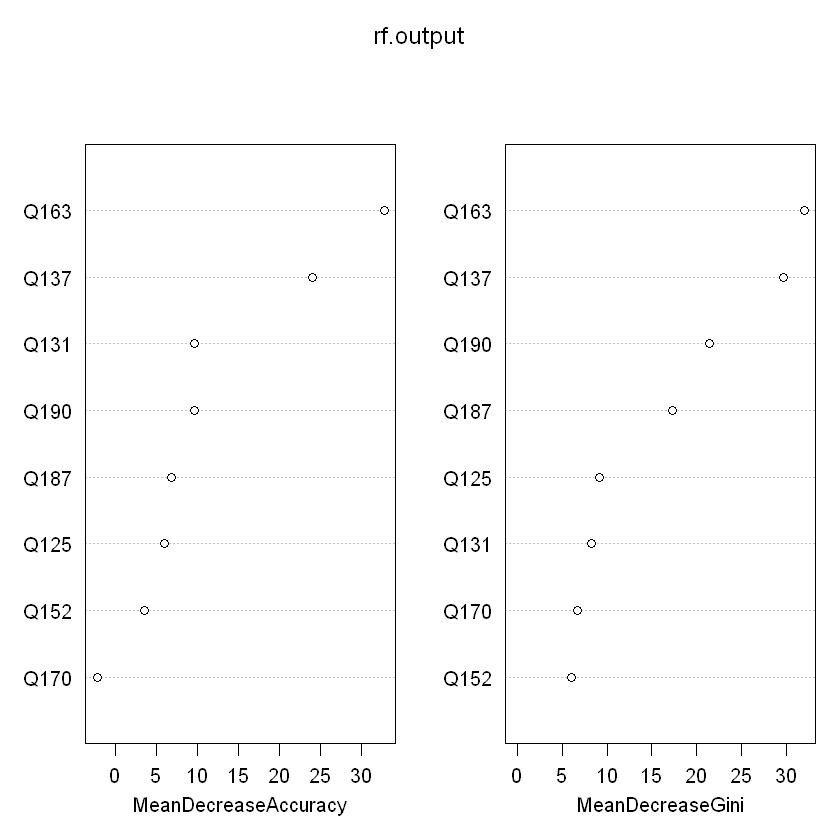

In [16]:
varImpPlot(rf.output)

## Extension: Adding more complex variables
So we've just done an ideal case, where everything works out properly. Let's have some fun and add one more variable. We're going to add Q155.  
Why use this question? Well, all the questions we've used so far only have a few answer choices. Q155 is the year of the faculty's degree so there are over 40 years represented in the data. Since this variable can take so many values, we call this variable a high cardinality variable.  
We'll use the same procedure as before, just adding Q155 to the quest vector. We'll call the new vector quest2

In [ ]:
quest2=c('Q125','Q131','Q137','Q152','Q163','Q170','Q187','Q190','Q155')
formula2=reformulate(quest2,'Q1')

In [ ]:
set.seed(1)
rf.output2<-randomForest(formula2,data=train, importance=TRUE)
print(rf.output2)

Look at the class.error on the "Yes" case. The model is classifying almost everything as "No" regardless of what the actual value is. Let's take a look at why the model became much worse by adding just one more question.

In [ ]:
predictions2=predict(rf.output2,test) #make the predictions on the "test" dataset
confusionMatrix(unlist(test['Q1']),unlist(predictions2),positive='Yes')

In [ ]:
comp_pred2=predict(rf.output2,type='prob') #generate probabilities of not having or having experience teaching computation
comp_train_perf2=prediction(comp_pred2[,2],train$Q1) #make object with just probabilities of having experience
comp_roc2=performance(comp_train_perf2,'tpr','fpr') #generate the fpr and tpr
plot(comp_roc2, main='ROC Curve') #plot the ROC curve
lines(c(0,1),c(0,1),type='l',lty=2) #add the chance line
performance(comp_train_perf2,'auc')@y.values[[1]] 

Let's look at the variable importances now.

In [ ]:
print(importance(rf.output2,type=1)) #Gini
print(importance(rf.output2,type=2)) #accuracy
varImpPlot(rf.output2)

What do you notice is different about the two plots?

In [ ]:
table(train$Q1,train$Q155)

## Extension: Conditional Inference Forests
Unfortunately, the random forest algorithm itself is based off of Gini coefficients so any bias in the Gini coefficient is inherent in the model. The accuracy-based importance doesn't suffer the same biases, but since they are derived from a biased forest, they are still biased.  
An alternative to random forest is a conditional inference forest. These are based off the ideas of conditional inference and are not known to be biased provided certain settings are used. To use these forests, we need the "party" package.  
To my knowledge, conditional inference forests are not available in python so that's why I'm using R.

In [ ]:
library(party)

We'll use the cforest() function to grow the forest now. All the syntax is the same otherwise though. The computation time is longer for this algorithm as an FYI.  
For whatever reason, cforest always uses mtry=5 instead of adjusting based on the number of questions. Typically, we use the square root of the number of questions, so we'll use that instead.  
  
**Not for the faint of heart:** to vary the settings of cforest, you need to use the cforest_control() function. This allows complete control over all the tuning parameters. The guiding rule from the party handbook is *if you don't understand it, don't mess with it!* Make sure to follow it here. The settings used in the Strobl et al paper are available by using controls=cforest_unbiased. The key thing to remember is that replace MUST be set equal to FALSE or cforest will be biased again. 

In [ ]:
crf_comp <- cforest(formula2,
                      data=train,
                    controls=cforest_control(teststat = "quad",
                        testtype = "Univ",
                        mincriterion = 0,
                        savesplitstats = FALSE,
                        ntree = 500, mtry = floor(sqrt(length(quest2))), replace = FALSE,
                        fraction = 0.632,trace=FALSE))

To get the OOB for the training data, use the cforestStats function from the Caret package.

In [ ]:
cforestStats(crf_comp)

Now, it's the same procedure as before. First, let's make predictions on the test dataset

In [ ]:
cif_pred=predict(crf_comp,test,OOB=TRUE)
confusionMatrix(unlist(test['Q1']),unlist(cif_pred),positive='Yes')

Now let's look at the ROC and AUC

In [ ]:
cif_pred2=predict(crf_comp,train, OOB=TRUE,type='prob') #get probabilities of each class for AUC
testdf2=unlist(cif_pred2)
testdf3=testdf2[c(FALSE,TRUE)] #take every other element starting with the second
cif_perf=prediction(as.data.frame(testdf3),as.data.frame(train$Q1)) #set the performance function
cif_roc=performance(cif_perf,'tpr','fpr')
plot(cif_roc, main='ROC Curve: cforest')
print('AUC from cforest():')
performance(cif_perf,'auc')@y.values[[1]]
print('As a reminder, AUC from randomforest():')
performance(comp_train_perf2,'auc')@y.values[[1]] 

Now let's get the importances. For cforest, we can use a third type of importance, the AUC importance. The AUC importance has all the benefits of the accuracy importance but performs better than the accuracy importance in the case of imbalanced classes. To use the AUC importance, we use varimpAUC(). Let's write a function to plot the results as well.

In [ ]:
cforestImpPlot <- function(x) {
    v <- varimpAUC(x)
    dotchart(v[order(v)])
}
cforestImpPlot(crf_comp)

Compare that plot with the results from random forest. What differences do you notice?

In [ ]:
varImpPlot(rf.output2)